In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns

from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from midterm_lib import DataProcessing, LogisticRegressionModel, evaluate_models

import warnings
warnings.filterwarnings("ignore")

import torch
from sklearn.linear_model import LogisticRegression

import pickle

from tqdm import tqdm

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
scenario_name = 'scenario_2'

In [3]:
dataset = pd.read_csv( f'./{scenario_name}/risk-train-processed.csv' )
dataset.replace( '?', None, inplace = True )

data_processing = DataProcessing( scenario_name, dataset, one_hot_encoding = True )

In [4]:
( id_train, id_test ), x_train, x_test, y_train, y_test = data_processing.get_train_test( test_size = 0.15, target = 'CLUSTER'  )

In [5]:
segmentation_model = LogisticRegression()
segmentation_model.fit( x_train[0], y_train )
y_pred = segmentation_model.predict( x_test[0] )

print( f'Accuracy: {accuracy_score( y_test, y_pred )}' )
print( f'Precision: {precision_score( y_test, y_pred, average = "macro" )}' )
print( f'Recall: {recall_score( y_test, y_pred, average = "macro" )}' )
print( f'F1 Score: {f1_score( y_test, y_pred, average = "macro" )}' )

Accuracy: 0.9989078001274233
Precision: 0.9986005678493867
Recall: 0.9898098878977887
F1 Score: 0.9919637075838822


In [6]:
# save segmentation_model
with open( f'./{scenario_name}/segmentation_model.pkl', 'wb' ) as f:
    pickle.dump( segmentation_model, f )

In [7]:
( id_train, id_test ), x_train, x_test, y_train, y_test = data_processing.get_train_test( test_size = 0.2, target = 'CLASS' )

x_train_onehot = x_train[0]
x_test_onehot = x_test[0]

x_train_class = x_train[1]
x_test_class = x_test[1]

print("Class distribution:", np.bincount( y_train ))

Class distribution: [55116  3478]


In [8]:
segmentation_classes_train = segmentation_model.predict( x_train_onehot )
segmentation_classes_test = segmentation_model.predict( x_test_onehot )

x_train_class = np.concatenate( ( segmentation_classes_train.reshape( -1, 1 ), x_train_class ), axis = 1 )
x_test_class = np.concatenate( ( segmentation_classes_test.reshape( -1, 1 ), x_test_class ), axis = 1 )

In [9]:
x_train_class.shape, x_test_class.shape, y_train.shape, y_test.shape

((58594, 33), (14649, 33), (58594,), (14649,))

In [10]:
x_train_onehot.shape, x_test_onehot.shape, y_train.shape, y_test.shape

((58594, 696), (14649, 696), (58594,), (14649,))

In [11]:
# ensemble_models = evaluate_models( x_train_class, x_test_class, y_train, y_test )

# save the ensemble models with pickle
# with open( f'./{scenario_name}/ensemble_models.pkl', 'wb' ) as file:
#    pickle.dump( ensemble_models, file )

In [12]:
with open( f'./{scenario_name}/ensemble_models.pkl', 'rb' ) as file:
    ensemble_models = pickle.load( file )

for m in ensemble_models:
    md = ensemble_models[m]['model']
    y_pred = md.predict( x_test_class )
    print(m)
    print(f'Report:\n{classification_report(y_test, y_pred)}')

Decision Tree
Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     13779
           1       0.77      0.80      0.79       870

    accuracy                           0.97     14649
   macro avg       0.88      0.89      0.89     14649
weighted avg       0.97      0.97      0.97     14649

Random Forest
Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13779
           1       1.00      0.46      0.63       870

    accuracy                           0.97     14649
   macro avg       0.98      0.73      0.81     14649
weighted avg       0.97      0.97      0.96     14649

K-Nearest Neighbors
Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     13779
           1       0.17      0.05      0.07       870

    accuracy                           0.93     14649
   macro avg       0.56      0.52      0.52     14649
we

In [13]:
# ( id_train, id_test ), x_train, x_test, y_train, y_test = data_processing.get_train_test( test_size = 0.2, target = 'CLASS', random_state = 12 )

x_train_onehot = x_train[0]
x_test_onehot = x_test[0]

x_train_class = x_train[1]
x_test_class = x_test[1]

segmentation_classes_train = segmentation_model.predict( x_train_onehot )
segmentation_classes_test = segmentation_model.predict( x_test_onehot )

x_train_class = np.concatenate( ( segmentation_classes_train.reshape( -1, 1 ), x_train_class ), axis = 1 )
x_test_class = np.concatenate( ( segmentation_classes_test.reshape( -1, 1 ), x_test_class ), axis = 1 )

In [14]:
ensemble_predictions_train = []
ensemble_predictions_test = []
for model_name, model_data in tqdm( ensemble_models.items() ):
    
    model = model_data['model']
    y_pred_train = model.predict( x_train_class )
    y_pred_test = model.predict( x_test_class )

    ensemble_predictions_train.append( y_pred_train )
    ensemble_predictions_test.append( y_pred_test )
    
ensemble_predictions_train = np.array( ensemble_predictions_train )
ensemble_predictions_test = np.array( ensemble_predictions_test )
ensemble_predictions_train = np.transpose( ensemble_predictions_train )
ensemble_predictions_test = np.transpose( ensemble_predictions_test )
ensemble_predictions_train.shape, ensemble_predictions_test.shape

100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


((58594, 5), (14649, 5))

In [15]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
device

device(type='cuda')

In [16]:
model = LogisticRegressionModel( 696, f'./{scenario_name}/logs/', 'logistic_regression', 76, device = device )
model.to( device )

LogisticRegressionModel()

In [17]:
model.k_fold_cross_validation_fit( ( x_train_onehot, segmentation_classes_train, ensemble_predictions_train ), y_train, k = 4, 
                                   epochs = 100, lr = 1e-4, rho = 1.5, batch_size = 128 )
model.save()

Fold 1


Epochs: 100%|██████████| 100/100 [02:14<00:00,  1.34s/epoch, loss=0.237]


Fold 1 Results:
Num High Risk predicted as Low Risk: 0
Num High Risk predicted as High Risk: 870

Num Low Risk predicted as Low Risk: 13779
Num Low Risk predicted as High Risk: 0

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Fold 2


Epochs: 100%|██████████| 100/100 [02:04<00:00,  1.25s/epoch, loss=0.265]


Fold 2 Results:
Num High Risk predicted as Low Risk: 0
Num High Risk predicted as High Risk: 870

Num Low Risk predicted as Low Risk: 13777
Num Low Risk predicted as High Risk: 2

Accuracy: 0.9998634719093453
Precision: 0.9977064220183486
Recall: 1.0
F1 Score: 0.9988518943742823
Fold 3


Epochs: 100%|██████████| 100/100 [02:04<00:00,  1.25s/epoch, loss=0.232]


Fold 3 Results:
Num High Risk predicted as Low Risk: 0
Num High Risk predicted as High Risk: 869

Num Low Risk predicted as Low Risk: 13778
Num Low Risk predicted as High Risk: 1

Accuracy: 0.9999317312943746
Precision: 0.9988505747126437
Recall: 1.0
F1 Score: 0.9994249568717654
Fold 4


Epochs: 100%|██████████| 100/100 [02:01<00:00,  1.22s/epoch, loss=0.214]

Fold 4 Results:
Num High Risk predicted as Low Risk: 0
Num High Risk predicted as High Risk: 869

Num Low Risk predicted as Low Risk: 13779
Num Low Risk predicted as High Risk: 0

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Cross-Validation Results (Averaged):
Average Accuracy: 0.99994880080093
Average Precision: 0.9991392491827481
Average Recall: 1.0
Average F1 Score: 0.9995692128115119



Saved to: ./scenario_2/logs/logistic_regression - 0





In [18]:
x_test_tensor = torch.tensor( x_test_onehot, dtype = torch.float32 ).to( device )
x_groups_tensor = torch.tensor( segmentation_classes_test, dtype = torch.long ).to( device )
x_ensemble_tensor = torch.tensor( ensemble_predictions_test, dtype = torch.float32 ).to( device )
y_test_tensor = torch.tensor( y_test, dtype = torch.float32 ).to( device )

y_hat = model.predict( ( x_test_tensor, x_groups_tensor, x_ensemble_tensor ) )

df = pd.DataFrame( { 'y_test': y_test, 'y_hat': y_hat, 'id': id_test } )
df = df.groupby( 'id' ).agg( { 'y_test': 'first', 'y_hat': 'mean' } )
df.head()

,y_test,y_hat
id,,
1,0,0.037580
3,0,0.029682
6,0,0.034330
10,0,0.027169
13,0,0.027208


In [19]:
# Multiply y_hat by 100 and round by 4 decimal places
y_hat = np.round( df['y_hat'].values * 100, 4 )

<Axes: ylabel='Count'>

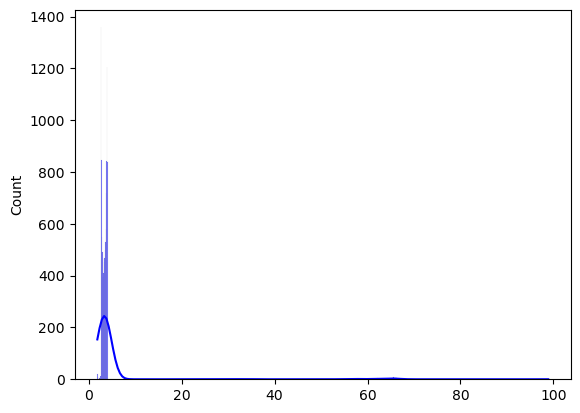

In [20]:
# plot the distribution of probabilities of y_hat for y = 0
sns.histplot( y_hat[ df['y_test'] == 0 ], color = 'blue', label = 'y = 0', kde = True )

<Axes: ylabel='Count'>

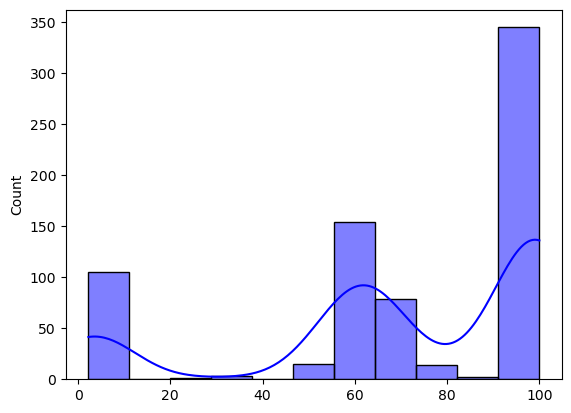

In [21]:
sns.histplot( y_hat[ df['y_test'] == 1 ], color = 'blue', label = 'y = 0', kde = True )

In [26]:
y_hat_bin = ( np.round( y_hat ) > 40 ).astype( int )

print( f"Num High Risk predicted as Low Risk: {len( y_hat_bin[ ( y_hat_bin == 0 ) & ( df['y_test'] == 1 ) ] ) }" )
print( f"Num High Risk predicted as High Risk: {len( y_hat_bin[ ( y_hat_bin == 1 ) & ( df['y_test'] == 1 ) ] ) }\n" )

print( f"Num Low Risk predicted as Low Risk: {len( y_hat_bin[ ( y_hat_bin == 0 ) & ( df['y_test'] == 0 ) ] ) }" )
print( f"Num Low Risk predicted as High Risk: {len( y_hat_bin[ ( y_hat_bin == 1 ) & ( df['y_test'] == 0 ) ] ) }\n" )

print( f"Accuracy: {accuracy_score( df['y_test'].values, y_hat_bin )}" )
print( f"Precision: {precision_score( df['y_test'].values, y_hat_bin )}" )
print( f"Recall: {recall_score( df['y_test'].values, y_hat_bin )}" )
print( f"F1: {f1_score( df['y_test'].values, y_hat_bin )}" )

Num High Risk predicted as Low Risk: 109
Num High Risk predicted as High Risk: 609

Num Low Risk predicted as Low Risk: 11270
Num Low Risk predicted as High Risk: 290

Accuracy: 0.9675028506271379
Precision: 0.6774193548387096
Recall: 0.8481894150417827
F1: 0.7532467532467533


In [23]:
# x_torch = torch.tensor( x_train_resampled, dtype = torch.float32 )
# y_torch = torch.tensor( y_train_resampled, dtype = torch.float32 )
# model.fit( x_torch, y_torch, epochs = 2000, lr = 1e-4, batch_size = 2048 )